In [1]:
from fit import *
import matplotlib.pyplot as plt
%matplotlib widget
from utils import plot_event, plot_generator, get_data_files, preceding_noise_file

First set up the MC configuration, i.e. the data part for which we're simulating data.

In [2]:
data_date_and_time = '20190504034237'
data_files = get_data_files(data_date_and_time)
noise_files = [preceding_noise_file(f) for f in data_files]
cfg = CounterConfig(data_files, noise_files)
ckv = GetCkv(cfg)

Now let's simulate an event with given shower parameters.

In [3]:
# pars = [6.479052e+02,1.705156e+06,5.890362e-01,2.461860e+00, 437., -660.,-29.0,0,70,0.]
pars = [500.,2.e6,np.deg2rad(40.),np.deg2rad(315.), 450., -660.,-29,0,70,0.]
ev = BasicParams.get_event(pars)
pe = ProcessEvents(cfg, frozen_noise=True)
real_nfits = pe.gen_nfits_from_event(ev)
print(ev)

Event(E=1538461538461538.5, Xmax=500.0, Nmax=2000000.0, zenith=0.6981317007977318, azimuth=5.497787143782138, corex=450.0, corey=-660.0, corez=-29, X0=0, Lambda=70)


We now have fitted NICHE waveforms, so we can estimate the core position with a tyro fit, and perform a plane fit to estimate the shower direction. We then compile this info into inital guesses to supply to the minimizer.

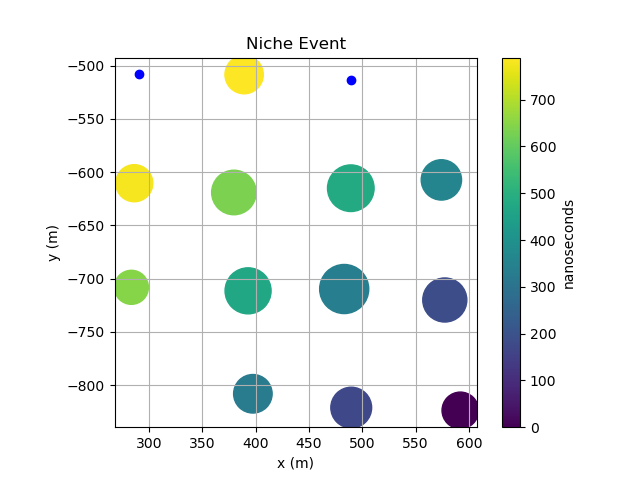

In [4]:
ty = tyro(real_nfits)
pf = NichePlane(real_nfits)
plot_event(ty)

In [5]:
pf

20240328084417.000025481
bardeen bell curie dirac feynman meitner newton noether rossi rubin rutherford yukawa 
nx =  0.4497 ny = -0.4567 z0 =   0.2
  +/- 0.0001   +/- 0.0001   +/-  0.0
  ( 7.82e-09  9.26e-10 -6.67e-08)
  ( 9.26e-10  1.02e-08 -1.67e-07)
  (-6.67e-08 -1.67e-07  6.92e-05)
th =  0.6958 ph =  5.4901

In [6]:
guess = make_guess(ty, pf,cfg)
# for i,p in enumerate(guess):
#     guess[i].value = pars[i]
[print(p) for p in guess];

FitParam(name='xmax', value=500.0, limits=(400.0, 800.0), error=50.0, fixed=False)
FitParam(name='nmax', value=1000000.0, limits=(10000.0, 100000000.0), error=100000.0, fixed=False)
FitParam(name='zenith', value=0.6957565422121836, limits=(0.0, 0.7957565422121836), error=0.017453292519943295, fixed=False)
FitParam(name='azimuth', value=5.490115944660358, limits=(5.390115944660359, 5.590115944660358), error=0.017453292519943295, fixed=False)
FitParam(name='corex', value=438.90445896432783, limits=(379.5, 489.2), error=5.0, fixed=False)
FitParam(name='corey', value=-665.7700052335351, limits=(-711.4, -615.1), error=5.0, fixed=False)
FitParam(name='corez', value=-29.0, limits=(-29.0, -29.0), error=1.0, fixed=True)
FitParam(name='x0', value=0.0, limits=(0, 0), error=1, fixed=True)
FitParam(name='lambda', value=70.0, limits=(70.0, 70.0), error=1, fixed=True)
FitParam(name='t_offset', value=0.0, limits=(-450.0, 450.0), error=10.0, fixed=False)


Fitting for the log of xmax and nmax rather than the values themselves results in a better fit, so we use the BasicParams mapper to go between the fitted parameters and the real ones.

In [7]:
guess = BasicParams.adjust_guess(guess)
# guess = pars

Now we can begin the fit procedure, starting by fitting the peaktimes for the shower angles.

Now with a good estimate for the angles, we can fit the pulse widths to estimate xmax.

In [8]:
pt = PeakTimes(real_nfits, BasicParams, cfg)
pt.target_parameters = ['zenith','azimuth']
m = init_minuit(pt, guess)
m.simplex(ncall=40)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.7 (χ²/ndof = 2.6)       │              Nfcn = 41               │
│ EDM = 0.216 (Goal: 0.1)          │           time = 14.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    500    │    50     │            │            │   400   │   800   │  yes  │
│ 1 │ nmax     │   1.0e6   │   0.1e6   │            │            │  10000  │  1e+08  │  yes  │
│ 2 │ zenith   │ 698.59e-3 │  0.09e-3  │            │            │    0    │0.795757 │       │
│ 3 │ azimuth  │  5.49990  │  0.00015  │            │            │ 5.39012 │ 5.59012 │       │
│ 4 │ corex    │    439    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -666    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -450   │   450   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [9]:
tpguess = update_guess(m)
pw = PulseWidth(real_nfits, BasicParams, cfg)
pw.target_parameters = ['xmax']
m = init_minuit(pw, tpguess)
m.simplex(ncall=40)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 26.36 (χ²/ndof = 2.4)      │              Nfcn = 15               │
│ EDM = 0.0106 (Goal: 0.1)         │            time = 6.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    478    │    14     │            │            │   400   │   800   │       │
│ 1 │ nmax     │   1.0e6   │   0.1e6   │            │            │  10000  │  1e+08  │  yes  │
│ 2 │ zenith   │ 698.59e-3 │  0.09e-3  │            │            │    0    │0.795757 │  yes  │
│ 3 │ azimuth  │  5.49990  │  0.00015  │            │            │ 5.39012 │ 5.59012 │  yes  │
│ 4 │ corex    │    439    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -666    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -450   │   450   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now, with a good estimate for log(xmax), we can fit the integrated pulse areas for nmax.

In [10]:
xmaxguess = update_guess(m)
pa = PulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['nmax']
m = init_minuit(pa, xmaxguess)
m.simplex(ncall=20)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 51.8 (χ²/ndof = 4.7)       │              Nfcn = 22               │
│ EDM = 0.0283 (Goal: 0.1)         │            time = 9.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    478    │    14     │            │            │   400   │   800   │  yes  │
│ 1 │ nmax     │  2.160e6  │  0.024e6  │            │            │  10000  │  1e+08  │       │
│ 2 │ zenith   │ 698.59e-3 │  0.09e-3  │            │            │    0    │0.795757 │  yes  │
│ 3 │ azimuth  │  5.49990  │  0.00015  │            │            │ 5.39012 │ 5.59012 │  yes  │
│ 4 │ corex    │    439    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -666    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -450   │   450   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now, with these values in the ballpark, we can simultaneously minimize both the shower profile and core position by fitting the normalized pulse areas.

In [11]:
nmaxguess = update_guess(m)
pa = NormalizedPulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['xmax','nmax','corex','corey']
m = init_minuit(pa, nmaxguess)
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.189 (χ²/ndof = 0.1)      │              Nfcn = 78               │
│ EDM = 0.0444 (Goal: 0.1)         │           time = 32.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    502    │     8     │            │            │   400   │   800   │       │
│ 1 │ nmax     │  1.98e6   │  0.06e6   │            │            │  10000  │  1e+08  │       │
│ 2 │ zenith   │ 698.59e-3 │  0.09e-3  │            │            │    0    │0.795757 │  yes  │
│ 3 │ azimuth  │  5.49990  │  0.00015  │            │            │ 5.39012 │ 5.59012 │  yes  │
│ 4 │ corex    │   449.1   │    1.9    │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │  -662.4   │    2.6    │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -450   │   450   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now that we're reasonably close to the minimum, we can zero in on it by freeing all the parameters simultaneously.

In [12]:
guess = update_guess(m)
at = AllTunka(real_nfits, BasicParams, cfg)
at.target_parameters = ['t_offset']
m = init_minuit(at, guess)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 256.4 (χ²/ndof = 5.5)      │              Nfcn = 73               │
│ EDM = 0.00382 (Goal: 0.0002)     │           time = 30.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    502    │     8     │            │            │   400   │   800   │  yes  │
│ 1 │ nmax     │  1.98e6   │  0.06e6   │            │            │  10000  │  1e+08  │  yes  │
│ 2 │ zenith   │ 698.59e-3 │  0.09e-3  │            │            │    0    │0.795757 │  yes  │
│ 3 │ azimuth  │  5.49990  │  0.00015  │            │            │ 5.39012 │ 5.59012 │  yes  │
│ 4 │ corex    │   449.1   │    1.9    │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │  -662.4   │    2.6    │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │  88.2474  │  0.0004   │            │            │  -450   │   450   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│          │     xmax     nmax   zenith  azimuth    corex    corey    corez       x0   lambda t_offset │
├──────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     xmax │        0        0        0        0        0        0        0        0        0        0 │
│     nmax │        0        0        0        0        0        0        0        0        0        0 │
│   zenith │        0        0        0        0        0        0        0        0        0        0 │
│  azimuth │        0        0        0        0        0        0        0        0        0        0 │
│    corex │        0        0        0        0        0        0        0        0        0        0 │
│    corey │        0        0        0        0        0        0        0        0        0        0 │
│    corez │        0        0        0        0        0        0        0        0        0        0 │
│       x0 │        0        0        0        0        0        0        0        0        0        0 │
│   lambda │        0        0        0        0        0        0        0        0        0        0 │
│ t_offset │        0        0        0        0        0        0        0        0        0 1.56e-07 │
└──────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [13]:
guess = update_guess(m)
at = AllSamples(real_nfits, BasicParams, cfg)
at.target_parameters = ['t_offset']
m = init_minuit(at, guess)


In [14]:
m.tol=.01
m.fixed = True
m.fixed['xmax'] = False
m.fixed['nmax'] = False
m.fixed['zenith'] = False
m.fixed['azimuth'] = False
m.fixed['corex'] = False
m.fixed['corey'] = False
m.fixed['t_offset'] = False
# m.scan()
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 150.8 (χ²/ndof = 0.9)      │              Nfcn = 418              │
│ EDM = 0.0634 (Goal: 0.01)        │           time = 136.7 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │   499.1   │    0.7    │            │            │   400   │   800   │       │
│ 1 │ nmax     │  2.008e6  │  0.006e6  │            │            │  10000  │  1e+08  │       │
│ 2 │ zenith   │698.106e-3 │ 0.027e-3  │            │            │    0    │0.795757 │       │
│ 3 │ azimuth  │ 5.497687  │ 0.000029  │            │            │ 5.39012 │ 5.59012 │       │
│ 4 │ corex    │  450.90   │   0.04    │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │  -660.25  │   0.04    │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │ 88.24461  │  0.00012  │            │            │  -450   │   450   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [15]:
# m.limits['xmax'] = (m.params['xmax'].value-20.,m.params['xmax'].value+20.)
# m.limits['nmax'] = (m.params['nmax'].value-2.e5,m.params['nmax'].value+2.e5)
# m.limits['zenith'] = (m.params['zenith'].value-5.e-2,m.params['zenith'].value+5.e-2)
# m.limits['azimuth'] = (m.params['azimuth'].value-5.e-2,m.params['azimuth'].value+5.e-2)
# m.limits['corex'] = (m.params['corex'].value-5.,m.params['corex'].value+5.)
# m.limits['corey'] = (m.params['corey'].value-5.,m.params['corey'].value+5.)
# m.limits['t_offset'] = (m.params['t_offset'].value-5.,m.params['t_offset'].value+5.)
# m.fixed = True
# m.fixed['xmax'] = False
# m.fixed['nmax'] = False
# m.fixed['zenith'] = False
# m.fixed['azimuth'] = False
# m.fixed['corex'] = False
# m.fixed['corey'] = False
# m.tol=1

In [16]:
# for par in guess:
#     m.errors[par.name] = par.error

In [17]:
fitpars = [p.value for p in m.params]
fit_ev = BasicParams.get_event(fitpars)
print(fit_ev)

Event(E=1544588281679970.2, Xmax=499.1097881684692, Nmax=2007964.7661839614, zenith=0.6981055003349297, azimuth=5.497686549989551, corex=450.90204069826, corey=-660.2464560949672, corez=-29.0, X0=0.0, Lambda=70.0)


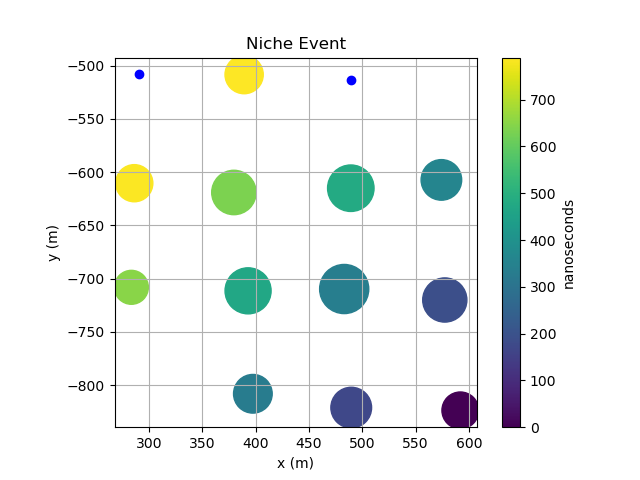

In [18]:
fit_nfits = pe.gen_nfits_from_event(fit_ev)
plot_event(tyro(fit_nfits))

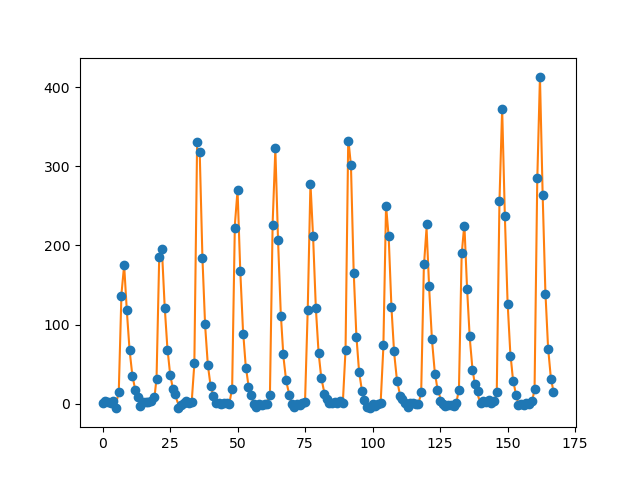

In [22]:
# at = AllTunka(real_nfits, BasicParams, cfg)
plt.figure()
plt.errorbar(np.arange(len(at.real_values)),at.real_values,yerr=at.error, fmt="o")
plt.plot(at.get_output(fitpars))
# plt.semilogy()

In [20]:
pars[-1] = 90
at.chi2(pars)/m.ndof

0.9473938386762645

In [21]:
pars

[500.0,
 2000000.0,
 0.6981317007977318,
 5.497787143782138,
 450.0,
 -660.0,
 -29,
 0,
 70,
 90]